### Read in CMIP6 daily SIE and SIA data, make time axis uniform, and remove leap day from greorgian calendar for those models that use that calendar instead of a no leap calendar. 
### Then compare the historical data to CDR SIA for model assessment in the paper

A. Jahn, May to June 2024, updated in Oct 2024 as part of reply to review of paper


In [1]:
import numpy as np
import xarray as xr
import glob 
import datetime
import matplotlib.pyplot as plt


In [2]:
#Convert daily data array with one time dimension in datetime64 to array of year, month, and day of the month
def to_year_month_day(ds):
    year = ds.time.dt.year
    month = ds.time.dt.month
    day = ds.time.dt.day
    
    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data),day=("time",day.data))

    # reshape the array to (..., "day","month", "year")
    return ds.set_index(time=("year", "month","day")).unstack("time")  

In [3]:
data_path = '/glade/work/ajahn/CMIP6_daily_sic_data/SIE_SIA_daily_CMIP6_Hist/'

In [4]:
#Model and ensemble member identifier
model_and_member = {
    'ACCESS-CM2_r1i1p1f1':'ACCESS-CM2_r1i1p1f1',
    'ACCESS-CM2_r2i1p1f1':'ACCESS-CM2_r2i1p1f1',
    'ACCESS-CM2_r3i1p1f1':'ACCESS-CM2_r3i1p1f1',
    'ACCESS-CM2_r4i1p1f1':'ACCESS-CM2_r4i1p1f1',
    'ACCESS-CM2_r5i1p1f1':'ACCESS-CM2_r5i1p1f1',
    'ACCESS-CM2_r6i1p1f1':'ACCESS-CM2_r6i1p1f1',
    'ACCESS-CM2_r7i1p1f1':'ACCESS-CM2_r7i1p1f1',
    'ACCESS-CM2_r8i1p1f1':'ACCESS-CM2_r8i1p1f1',
    'ACCESS-CM2_r9i1p1f1':'ACCESS-CM2_r9i1p1f1',
    'ACCESS-CM2_r10i1p1f1':'ACCESS-CM2_r10i1p1f1',
    'AWI-CM-1-1-MR_r1i1p1f1':'AWI-CM-1-1-MR_r1i1p1f1',
    'BCC-CSM2-MR_r1i1p1f1':'BCC-CSM2-MR_r1i1p1f1', 
    'BCC-ESM1_r1i1p1f1':'BCC-ESM1_r1i1p1f1',       
    'CanESM5_r1i1p1f1':'CanESM5_r1i1p1f1',
    'CanESM5_r1i1p2f1':'CanESM5_r1i1p2f1',
    'CanESM5_r10i1p1f1':'CanESM5_r10i1p1f1',
    'CanESM5_r10i1p2f1':'CanESM5_r10i1p2f1',
    'CanESM5_r2i1p1f1':'CanESM5_r2i1p1f1',
    'CanESM5_r2i1p2f1':'CanESM5_r2i1p2f1',
    'CanESM5_r3i1p1f1':'CanESM5_r3i1p1f1',
    'CanESM5_r3i1p2f1':'CanESM5_r3i1p2f1',
    'CanESM5_r4i1p1f1':'CanESM5_r4i1p1f1',
    'CanESM5_r4i1p2f1':'CanESM5_r4i1p2f1',
    'CanESM5_r5i1p1f1':'CanESM5_r5i1p1f1',
    'CanESM5_r5i1p2f1':'CanESM5_r5i1p2f1',
    'CanESM5_r6i1p1f1':'CanESM5_r6i1p2f1',
    'CanESM5_r6i1p2f1':'CanESM5_r6i1p2f1',
    'CanESM5_r7i1p1f1':'CanESM5_r7i1p1f1',
    'CanESM5_r7i1p2f1':'CanESM5_r7i1p2f1',
    'CanESM5_r8i1p1f1':'CanESM5_r8i1p1f1',
    'CanESM5_r8i1p2f1':'CanESM5_r8i1p2f1',
    'CanESM5_r9i1p1f1':'CanESM5_r9i1p1f1',
    'CanESM5_r9i1p2f1':'CanESM5_r9i1p2f1',
    'CESM2_r1i1p1f1':'CESM2_r1i1p1f1',
    'CESM2_r2i1p1f1':'CESM2_r2i1p1f1',
    'CESM2_r3i1p1f1':'CESM2_r3i1p1f1',
    'CESM2_r4i1p1f1':'CESM2_r4i1p1f1',
    'CESM2_r5i1p1f1':'CESM2_r5i1p1f1',
    'CESM2_r6i1p1f1':'CESM2_r6i1p1f1',
    'CESM2_r7i1p1f1':'CESM2_r7i1p1f1',
    'CESM2_r8i1p1f1':'CESM2_r8i1p1f1',
    'CESM2_r9i1p1f1':'CESM2_r9i1p1f1',
    'CESM2_r10i1p1f1':'CESM2_r10i1p1f1',
    'CNRM-CM6-1_r1i1p1f2':'CNRM-CM6-1_r1i1p1f2',
    'CNRM-CM6-1-HR_r1i1p1f2':'CNRM-CM6-1-HR_r1i1p1f2', 
    'CNRM-ESM2-1_r1i1p1f2':'CNRM-ESM2-1_r1i1p1f2', 
    'CMCC-CM2-HR4_r1i1p1f1':'CMCC-CM2-HR4_r1i1p1f1',
    'CMCC-CM2-SR5_r1i1p1f1':'CMCC-CM2-SR5_r1i1p1f1',
    'CMCC-ESM2_r1i1p1f1':'CMCC-ESM2_r1i1p1f1',
    'EC-Earth3_r1i1p1f1':'EC-Earth3_r1i1p1f1',
    'EC-Earth3_r10i1p1f1':'EC-Earth3_r10i1p1f1',
    'EC-Earth3_r12i1p1f1':'EC-Earth3_r12i1p1f1',
    'EC-Earth3_r14i1p1f1':'EC-Earth3_r14i1p1f1',
    'EC-Earth3_r16i1p1f1':'EC-Earth3_r16i1p1f1',
    #'EC-Earth3_r4i1p1f1':'EC-Earth3_r4i1p1f1', #part of file is corrupted
    #'EC-Earth3_r5i1p1f1':'EC-Earth3_r5i1p1f1', # file can't be found
    'EC-Earth3-CC_r1i1p1f1':'EC-Earth3-CC_r1i1p1f1',
    'EC-Earth3-AerChem_r1i1p1f1':'EC-Earth3-AerChem_r1i1p1f1',
    'EC-Earth3-AerChem_r1i1p4f1':'EC-Earth3-AerChem_r1i1p4f1',
    'EC-Earth3-AerChem_r3i1p1f1':'EC-Earth3-AerChem_r3i1p1f1',
    'EC-Earth3-AerChem_r4i1p1f1':'EC-Earth3-AerChem_r4i1p1f1',
    'EC-Earth3-Veg-LR_r1i1p1f1':'EC-Earth3-Veg-LR_r1i1p1f1',
    'EC-Earth3-Veg-LR_r2i1p1f1':'EC-Earth3-Veg-LR_r3i1p1f1',
    'EC-Earth3-Veg-LR_r3i1p1f1':'EC-Earth3-Veg-LR_r2i1p1f1',
    'EC-Earth3-Veg_r1i1p1f1':'EC-Earth3-Veg_r1i1p1f1',
    'EC-Earth3-Veg_r4i1p1f1':'EC-Earth3-Veg_r4i1p1f1',
    'EC-Earth3-Veg_r6i1p1f1':'EC-Earth3-Veg_r6i1p1f1',
    'GISS-E2-1-G_r1i1p1f1':'GISS-E2-1-G_r1i1p1f1', #siconca
    'IPSL-CM5A2-INCA_r1i1p1f1':'IPSL-CM5A2-INCA_r1i1p1f1',
    'IPSL-CM6A-LR-INCA_r1i1p1f1':'IPSL-CM6A-LR-INCA_r1i1p1f1',
    'IPSL-CM6A-LR_r1i1p1f1':'IPSL-CM6A-LR_r1i1p1f1',
    'MIROC6_r1i1p1f1':'MIROC6_r1i1p1f1',
    'MIROC6_r2i1p1f1':'MIROC6_r2i1p1f1',
    'MIROC6_r3i1p1f1':'MIROC6_r3i1p1f1',
    'MIROC-ES2L_r10i1p1f2':'MIROC-ES2L_r10i1p1f2',
    'MIROC-ES2L_r1i1p1f2':'MIROC-ES2L_r1i1p1f2',
    'MIROC-ES2L_r2i1p1f2':'MIROC-ES2L_r2i1p1f2', 
    'MIROC-ES2L_r3i1p1f2':'MIROC-ES2L_r3i1p1f2', 
    'MIROC-ES2L_r4i1p1f2':'MIROC-ES2L_r4i1p1f2',
    'MIROC-ES2L_r5i1p1f2':'MIROC-ES2L_r5i1p1f2',
    'MIROC-ES2L_r6i1p1f2':'MIROC-ES2L_r6i1p1f2',
    'MIROC-ES2L_r7i1p1f2':'MIROC-ES2L_r7i1p1f2',
    'MIROC-ES2L_r8i1p1f2':'MIROC-ES2L_r8i1p1f2',
    'MIROC-ES2H_r1i1p4f2':'MIROC-ES2H_r1i1p4f2',
    'MIROC-ES2H_r2i1p4f2':'MIROC-ES2H_r2i1p4f2',
    'MIROC-ES2H_r3i1p4f2':'MIROC-ES2H_r3i1p4f2',
    'MPI-ESM-1-2-HAM_r1i1p1f1':'MPI-ESM-1-2-HAM_r1i1p1f1',
    'MPI-ESM-1-2-HAM_r2i1p1f1':'MPI-ESM-1-2-HAM_r2i1p1f1',
    'MPI-ESM-1-2-HAM_r3i1p1f1':'MPI-ESM-1-2-HAM_r3i1p1f1',
    'MPI-ESM1-2-HR_r1i1p1f1':'MPI-ESM1-2-HR_r1i1p1f1',
    'MPI-ESM1-2-LR_r2i1p1f1':'MPI-ESM1-2-LR_r2i1p1f1',  
    'MPI-ESM1-2-LR_r3i1p1f1':'MPI-ESM1-2-LR_r3i1p1f1',  
    'MPI-ESM1-2-LR_r4i1p1f1':'MPI-ESM1-2-LR_r4i1p1f1',  
    'MPI-ESM1-2-LR_r5i1p1f1':'MPI-ESM1-2-LR_r5i1p1f1',  
    'MPI-ESM1-2-LR_r6i1p1f1':'MPI-ESM1-2-LR_r6i1p1f1',  
    'MPI-ESM1-2-LR_r7i1p1f1':'MPI-ESM1-2-LR_r7i1p1f1',  
    'MPI-ESM1-2-LR_r8i1p1f1':'MPI-ESM1-2-LR_r8i1p1f1',  
    'MPI-ESM1-2-LR_r9i1p1f1':'MPI-ESM1-2-LR_r9i1p1f1',  
    'MPI-ESM1-2-LR_r10i1p1f1':'MPI-ESM1-2-LR_r10i1p1f1',  
    'MPI-ESM1-2-LR_r11i1p1f1':'MPI-ESM1-2-LR_r11i1p1f1',  
    'MPI-ESM1-2-LR_r12i1p1f1':'MPI-ESM1-2-LR_r12i1p1f1',  
    'MPI-ESM1-2-LR_r13i1p1f1':'MPI-ESM1-2-LR_r13i1p1f1',  
    'MPI-ESM1-2-LR_r14i1p1f1':'MPI-ESM1-2-LR_r14i1p1f1',  
    'MPI-ESM1-2-LR_r15i1p1f1':'MPI-ESM1-2-LR_r15i1p1f1',  
    'MPI-ESM1-2-LR_r16i1p1f1':'MPI-ESM1-2-LR_r16i1p1f1',  
    'MPI-ESM1-2-LR_r17i1p1f1':'MPI-ESM1-2-LR_r17i1p1f1',  
    'MPI-ESM1-2-LR_r18i1p1f1':'MPI-ESM1-2-LR_r18i1p1f1',  
    'MPI-ESM1-2-LR_r19i1p1f1':'MPI-ESM1-2-LR_r19i1p1f1',  
    'MPI-ESM1-2-LR_r20i1p1f1':'MPI-ESM1-2-LR_r20i1p1f1',  
    'MPI-ESM1-2-LR_r21i1p1f1':'MPI-ESM1-2-LR_r21i1p1f1',  
    'MPI-ESM1-2-LR_r22i1p1f1':'MPI-ESM1-2-LR_r22i1p1f1',  
    'MPI-ESM1-2-LR_r23i1p1f1':'MPI-ESM1-2-LR_r23i1p1f1',  
    'MPI-ESM1-2-LR_r24i1p1f1':'MPI-ESM1-2-LR_r24i1p1f1',  
    'MPI-ESM1-2-LR_r25i1p1f1':'MPI-ESM1-2-LR_r25i1p1f1',  
    'MPI-ESM1-2-LR_r26i1p1f1':'MPI-ESM1-2-LR_r26i1p1f1',  
    'MPI-ESM1-2-LR_r27i1p1f1':'MPI-ESM1-2-LR_r27i1p1f1',  
    'MPI-ESM1-2-LR_r28i1p1f1':'MPI-ESM1-2-LR_r28i1p1f1',  
    'MPI-ESM1-2-LR_r29i1p1f1':'MPI-ESM1-2-LR_r29i1p1f1',  
    'MPI-ESM1-2-LR_r30i1p1f1':'MPI-ESM1-2-LR_r30i1p1f1',  
    'MPI-ESM1-2-LR_r31i1p1f1':'MPI-ESM1-2-LR_r31i1p1f1',  
    'MPI-ESM1-2-LR_r32i1p1f1':'MPI-ESM1-2-LR_r32i1p1f1',  
    'MPI-ESM1-2-LR_r33i1p1f1':'MPI-ESM1-2-LR_r33i1p1f1',  
    'MPI-ESM1-2-LR_r34i1p1f1':'MPI-ESM1-2-LR_r34i1p1f1',  
    'MPI-ESM1-2-LR_r35i1p1f1':'MPI-ESM1-2-LR_r35i1p1f1',  
    'MPI-ESM1-2-LR_r36i1p1f1':'MPI-ESM1-2-LR_r36i1p1f1',  
    'MPI-ESM1-2-LR_r37i1p1f1':'MPI-ESM1-2-LR_r37i1p1f1',  
    'MPI-ESM1-2-LR_r38i1p1f1':'MPI-ESM1-2-LR_r38i1p1f1',  
    'MPI-ESM1-2-LR_r39i1p1f1':'MPI-ESM1-2-LR_r39i1p1f1',  
    'MPI-ESM1-2-LR_r40i1p1f1':'MPI-ESM1-2-LR_r40i1p1f1',  
    'MPI-ESM1-2-LR_r41i1p1f1':'MPI-ESM1-2-LR_r41i1p1f1',  
    'MPI-ESM1-2-LR_r42i1p1f1':'MPI-ESM1-2-LR_r42i1p1f1',  
    'MPI-ESM1-2-LR_r43i1p1f1':'MPI-ESM1-2-LR_r43i1p1f1',  
    'MPI-ESM1-2-LR_r44i1p1f1':'MPI-ESM1-2-LR_r44i1p1f1',  
    'MPI-ESM1-2-LR_r45i1p1f1':'MPI-ESM1-2-LR_r45i1p1f1',  
    'MPI-ESM1-2-LR_r46i1p1f1':'MPI-ESM1-2-LR_r46i1p1f1',  
    'MPI-ESM1-2-LR_r47i1p1f1':'MPI-ESM1-2-LR_r47i1p1f1',  
    'MPI-ESM1-2-LR_r48i1p1f1':'MPI-ESM1-2-LR_r48i1p1f1',  
    'MPI-ESM1-2-LR_r49i1p1f1':'MPI-ESM1-2-LR_r49i1p1f1',  
    'MPI-ESM1-2-LR_r50i1p1f1':'MPI-ESM1-2-LR_r50i1p1f1',  
    'NorESM2-LM_r1i1p1f1':'NorESM2-LM_r1i1p1f1',
    'NorESM2-LM_r2i1p1f1':'NorESM2-LM_r2i1p1f1',
    'NorESM2-LM_r3i1p1f1':'NorESM2-LM_r3i1p1f1',
    'NorESM2-MM_r1i1p1f1':'NorESM2-MM_r1i1p1f1', 
    'NESM3_r1i1p1f1':'NESM3_r1i1p1f1',
}




In [5]:
# Read in all individual files, remove leap days if present, 
# and put on uniform time axis of the same type for concatanating
file_new=[]
all_GCM_names = []


        

for GCM_ in np.sort(list(model_and_member.keys())):
    #Save all GCM names in order
    all_GCM_names.append(GCM_)
    #load the SIE and SIA data file
    file = xr.open_dataset(data_path+'SIA_SIE_hist_{}.nc'.format(GCM_))
    print(datetime.datetime.now(), GCM_)
    #Check if in million km2 (processed by Alex) or in km2 (processed by Céline) and make all million km2
    if np.max(file['Arctic_SIA']) >100:
        file['Arctic_SIA']=file['Arctic_SIA']/1e12
        file['Arctic_SIE']=file['Arctic_SIE']/1e12
    
    #Remove leap days, if present, so all files have 12775 days for 19800101-20141231
    print(file.sizes['time'])
    if file.sizes['time'] == 12784 :
        if not type(file) is datetime.date: #If no time dimension, add it
           date = xr.cftime_range(start='1980-01-01', periods=len(file['time']), 
                           freq='D', calendar='standard'
                           )     
           file['time'] = date
           file["time"] = file["time"].astype("datetime64[ns]")

        file=file.convert_calendar('noleap',align_on='date') #remove leap days from obs data 
        print(file.sizes['time'])
    else:
        print('Already no leap calendar')
        if not type(file) is datetime.date: #If no time dimension, add it
           date = xr.cftime_range(start='1980-01-01', periods=len(file['time']), 
                           freq='D', calendar='noleap'
                           )     
           file['time'] = date
           file["time"] = file["time"].astype("datetime64[ns]")

    #overwrite time so it's the same in all GCMs to enable averaging by timestep
    dates = xr.cftime_range(start='1980-01-01', periods=len(file['time']), 
                           freq='D', calendar='noleap'
                           )     
    file['time'] = dates

    
    file_new.append(file)
  

2024-10-11 17:47:36.628871 ACCESS-CM2_r10i1p1f1
12784
12775
2024-10-11 17:47:37.369022 ACCESS-CM2_r1i1p1f1
12784
12775
2024-10-11 17:47:37.929457 ACCESS-CM2_r2i1p1f1
12784
12775
2024-10-11 17:47:38.626487 ACCESS-CM2_r3i1p1f1
12784
12775
2024-10-11 17:47:39.342729 ACCESS-CM2_r4i1p1f1
12784
12775
2024-10-11 17:47:40.304141 ACCESS-CM2_r5i1p1f1
12784
12775
2024-10-11 17:47:40.862318 ACCESS-CM2_r6i1p1f1
12784
12775
2024-10-11 17:47:41.566966 ACCESS-CM2_r7i1p1f1
12784
12775
2024-10-11 17:47:42.171698 ACCESS-CM2_r8i1p1f1
12784
12775
2024-10-11 17:47:42.870539 ACCESS-CM2_r9i1p1f1
12784
12775
2024-10-11 17:47:43.404613 AWI-CM-1-1-MR_r1i1p1f1
12784
12775
2024-10-11 17:47:44.007145 BCC-CSM2-MR_r1i1p1f1
12775
Already no leap calendar
2024-10-11 17:47:44.178762 BCC-ESM1_r1i1p1f1
12775
Already no leap calendar
2024-10-11 17:47:44.482192 CESM2_r10i1p1f1
12775
Already no leap calendar
2024-10-11 17:47:44.679966 CESM2_r1i1p1f1
12775
Already no leap calendar
2024-10-11 17:47:44.975200 CESM2_r2i1p1f1
127

In [6]:
CMIP6_daily_SIE_SIA_1980_2014=xr.concat((file_new), dim='GCM')
CMIP6_daily_SIE_SIA_1980_2014['GCM'] = all_GCM_names


In [23]:
#Optional: Save to a netcdf file. If desired, activate lines below
#assign metadata to the NetCDF file
# CMIP6_daily_SIE_SIA_1980_2014.attrs = {'Description':'Daily CMIP6 Arctic SIE and SIA data in million km2 from all analyzed GCMs, for 1980-01-01 to 2014-12-31 from the historical CMIP6 simulations. Calendar has no leap years.'}
#save to NetCDF file
# CMIP6_daily_SIE_SIA_1980_2014.to_netcdf('Daily_all_CMIP6_SIE_SIA_1980_2014.nc')

In [24]:
#Convert daily data array with one time dimension in datetime64 to array of year and julien day of the year in two columns
def to_year_dayofyear(ds):
    year = ds.time.dt.year
    dayofyear = ds.time.dt.dayofyear
    
    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time",dayofyear.data))

    # reshape the array to (..., "daofyear", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  

In [25]:
#Change array structure to year, day from days
daily_SIE_Dayofyear=to_year_dayofyear(CMIP6_daily_SIE_SIA_1980_2014['Arctic_SIE'])
daily_SIA_Dayofyear=to_year_dayofyear(CMIP6_daily_SIE_SIA_1980_2014['Arctic_SIA'])

In [26]:
#Minimum SIE each year
SIE_min=daily_SIE_Dayofyear.min(dim='dayofyear')
#Minimum Day of year this minimum SIE e=occurs
SIE_min_day=daily_SIE_Dayofyear.idxmin(dim='dayofyear')

#Minimum SIA each year
SIA_min=daily_SIA_Dayofyear.min(dim='dayofyear')
#Minimum Day of year this minimum SIA e=occurs
SIA_min_day=daily_SIA_Dayofyear.idxmin(dim='dayofyear')

# Criteria 2
### Check if a models daily minimum is in obs range of 238-272 (Aug 26 to Sept 29)


In [28]:
#What is the internal variability for the daily SIA minimum? 1980-2014. Based on models with 5 or more members
MPI_clim=[]
EC_clim=[]
CanESM5_clim=[]
MIROC_clim=[]
ACCESS_clim=[]
CESM2_clim=[]

for GCM_ in np.sort(list(model_and_member.keys())):
    if 'MPI-ESM1-2-LR_' in GCM_:
        temp1=np.std(SIE_min_day.sel(GCM=GCM_))
        MPI_clim.append(temp1)
    if 'CESM2_' in GCM_:
        temp1a=np.std(SIE_min_day.sel(GCM=GCM_))
        CESM2_clim.append(temp1a)    
    if 'EC-Earth3_' in GCM_:
        temp2=np.std(SIE_min_day.sel(GCM=GCM_))
        EC_clim.append(temp2)
    if 'CanESM5_' in GCM_:
        temp3=np.std(SIE_min_day.sel(GCM=GCM_))
        CanESM5_clim.append(temp3)
    if 'ACCESS-CM2_' in GCM_:
        temp4=np.std(SIE_min_day.sel(GCM=GCM_))
        ACCESS_clim.append(temp4)
    if 'MIROC-ES2L_' in GCM_:
        temp5=np.std(SIE_min_day.sel(GCM=GCM_))
        MIROC_clim.append(temp5)




In [29]:
print('MIROC-ES2L std:',np.mean(MIROC_clim))
print('CanESM5 std:',np.mean(CanESM5_clim))
print('ACCESS-CM2 std:',np.mean(ACCESS_clim))
print('MPI-ESM1-2-LR std:',np.mean(MPI_clim))
print('EC-Earth3 std:',np.mean(EC_clim))
print('CESM2 std:',np.mean(CESM2_clim))

MIROC-ES2L std: 3.293135780643966
CanESM5 std: 5.378557355742081
ACCESS-CM2 std: 5.467020505423256
MPI-ESM1-2-LR std: 5.2124427801179865
EC-Earth3 std: 6.965418240087667
CESM2 std: 4.5725856596781895


In [30]:
#Average standard deviation in the ice-free day
average_int_var=(np.mean(CanESM5_clim)+np.mean(MPI_clim)+np.mean(EC_clim)+np.mean(MIROC_clim)+np.mean(ACCESS_clim)+np.mean(CESM2_clim))/6
print(average_int_var)

5.148193386948858


In [31]:
#Get the SIA and SIE based on the CDR SIC data, 1980-2014, pole hole filled, no leap years
daily_CDR = xr.open_dataset('../NSIDC_CDR_daily_v4_SIA_SIE_197901-202312_no_leap.nc')
#There is some daily data missing, so need to set those to nan so it isn't detected as the minimum
daily_CDR['CDR_SIA'][ daily_CDR['CDR_SIA']==0 ] = np.nan
daily_CDR['BT_SIA'][ daily_CDR['BT_SIA']==0 ] = np.nan
daily_CDR['NT_SIA'][ daily_CDR['NT_SIA']==0 ] = np.nan

daily_SIA_Dayofyear=to_year_dayofyear(CMIP6_daily_SIE_SIA_1980_2014['Arctic_SIA'])
obs_min_day_CDR_2023=to_year_dayofyear(daily_CDR['CDR_SIA']).sel(year=2023).idxmin(dim='dayofyear')

obs_min_day_CDR=to_year_dayofyear(daily_CDR['CDR_SIA']).sel(year=slice(1980,2014)).idxmin(dim='dayofyear')
obs_min_day_BT=to_year_dayofyear(daily_CDR['BT_SIA']).sel(year=slice(1980,2014)).idxmin(dim='dayofyear')
obs_min_day_NT=to_year_dayofyear(daily_CDR['NT_SIA']).sel(year=slice(1980,2014)).idxmin(dim='dayofyear')

print('Daily min days from Obs')
print('CDR',obs_min_day_CDR.values)
print('NT',obs_min_day_NT.values)
print('BT',obs_min_day_BT.values)

print('Standard Deviation of the observed minimum day')      
print('CDR',np.std(obs_min_day_CDR.values))
print('NT',np.std(obs_min_day_NT.values))
print('BT',np.std(obs_min_day_BT.values))

print('Earliest observed minimum day')
print('CDR',np.min(obs_min_day_CDR.values))
print('NT',np.min(obs_min_day_NT.values))
print('BT',np.min(obs_min_day_BT.values))

print('Latest observed minimum day')
print('CDR',np.max(obs_min_day_CDR.values))
print('NT',np.max(obs_min_day_NT.values))
print('BT',np.max(obs_min_day_BT.values))

print('Average observed annual minimum day')
print('CDR',np.mean(obs_min_day_CDR.values))
print('NT',np.mean(obs_min_day_NT.values))
print('BT',np.mean(obs_min_day_BT.values))

print('Day of daily minimum in 2023',obs_min_day_CDR_2023.values)

Daily min days from Obs
CDR [238. 253. 252. 249. 255. 250. 251. 241. 244. 253. 261. 259. 244. 251.
 249. 251. 252. 245. 254. 255. 252. 260. 248. 248. 251. 264. 257. 257.
 251. 255. 260. 249. 258. 252. 259.]
NT [248. 251. 256. 245. 255. 254. 253. 245. 246. 254. 264. 261. 244. 249.
 248. 272. 251. 260. 254. 259. 246. 260. 248. 248. 250. 246. 265. 250.
 251. 251. 250. 248. 258. 251. 252.]
BT [250. 254. 252. 255. 255. 250. 249. 241. 244. 255. 246. 261. 244. 246.
 249. 251. 251. 245. 253. 254. 245. 260. 254. 248. 251. 264. 257. 258.
 251. 255. 260. 249. 258. 252. 260.]
Standard Deviation of the observed minimum day
CDR 5.682482929573828
NT 6.3378358502967025
BT 5.439537795490663
Earliest observed minimum day
CDR 238.0
NT 244.0
BT 241.0
Latest observed minimum day
CDR 264.0
NT 272.0
BT 264.0
Average observed annual minimum day
CDR 252.22857142857143
NT 252.65714285714284
BT 252.2
Day of daily minimum in 2023 254.0


In [34]:
for GCM_ in np.sort(list(model_and_member.keys())):
        if np.min(SIE_min_day.sel(GCM=GCM_)) < 238-5:
            print(GCM_,'Too early daily minimum with min at',np.min(SIE_min_day.sel(GCM=GCM_).values))
        if np.max(SIE_min_day.sel(GCM=GCM_)) > 272+5:
            print(GCM_,'Too late daily minimum with max at',np.max(SIE_min_day.sel(GCM=GCM_).values))

CESM2_r8i1p1f1 Too late daily minimum with max at 278.0
CMCC-CM2-SR5_r1i1p1f1 Too early daily minimum with min at 206.0
EC-Earth3-AerChem_r1i1p1f1 Too early daily minimum with min at 223.0
EC-Earth3-AerChem_r1i1p4f1 Too early daily minimum with min at 215.0
EC-Earth3-AerChem_r3i1p1f1 Too early daily minimum with min at 221.0
EC-Earth3-AerChem_r4i1p1f1 Too early daily minimum with min at 225.0
EC-Earth3-CC_r1i1p1f1 Too early daily minimum with min at 229.0
EC-Earth3-Veg-LR_r1i1p1f1 Too early daily minimum with min at 225.0
EC-Earth3-Veg_r1i1p1f1 Too early daily minimum with min at 228.0
EC-Earth3-Veg_r4i1p1f1 Too early daily minimum with min at 232.0
EC-Earth3-Veg_r6i1p1f1 Too early daily minimum with min at 222.0
EC-Earth3_r10i1p1f1 Too early daily minimum with min at 228.0
EC-Earth3_r12i1p1f1 Too early daily minimum with min at 232.0
EC-Earth3_r14i1p1f1 Too early daily minimum with min at 231.0
EC-Earth3_r16i1p1f1 Too early daily minimum with min at 225.0


#### Only exclude models with no members that fall within the range
#### Here that means excluding CMCC-CM2-SR5, EC-Earth3-AerChem, EC-Earth3-CC, EC-Earth3-Veg
#### EC-Earth3 has one (r1) that does meet the criteria so it stays in for this criteria, EC-Earth3-Veg-LR has 2 that meet criteria.

## Criteria 1

In [35]:

daily_SIE=to_year_month_day(daily_CDR['CDR_SIE'])
daily_SIA=to_year_month_day(daily_CDR['CDR_SIA'])

daily_BT_SIE=to_year_month_day(daily_CDR['BT_SIE'])
daily_BT_SIA=to_year_month_day(daily_CDR['BT_SIA'])

daily_NT_SIE=to_year_month_day(daily_CDR['NT_SIE'])
daily_NT_SIA=to_year_month_day(daily_CDR['NT_SIA'])

#Take only 1980-1999
daily_SIE_1995_2014=daily_SIE.sel(year=slice(1995,2014))
daily_SIA_1995_2014=daily_SIA.sel(year=slice(1995,2014))

daily_BT_SIE_1995_2014=daily_BT_SIE.sel(year=slice(1995,2014))
daily_BT_SIA_1995_2014=daily_BT_SIA.sel(year=slice(1995,2014))

daily_NT_SIE_1995_2014=daily_NT_SIE.sel(year=slice(1995,2014))
daily_NT_SIA_1995_2014=daily_NT_SIA.sel(year=slice(1995,2014))


In [36]:
#Make climatology

SIE_CDR_mclim_1995_2014=daily_SIE_1995_2014.mean('day').mean('year')
SIA_CDR_mclim_1995_2014=daily_SIA_1995_2014.mean('day').mean('year')

SIE_BT_mclim_1995_2014=daily_BT_SIE_1995_2014.mean('day').mean('year')
SIA_BT_mclim_1995_2014=daily_BT_SIA_1995_2014.mean('day').mean('year')

SIE_NT_mclim_1995_2014=daily_NT_SIE_1995_2014.mean('day').mean('year')
SIA_NT_mclim_1995_2014=daily_NT_SIA_1995_2014.mean('day').mean('year')



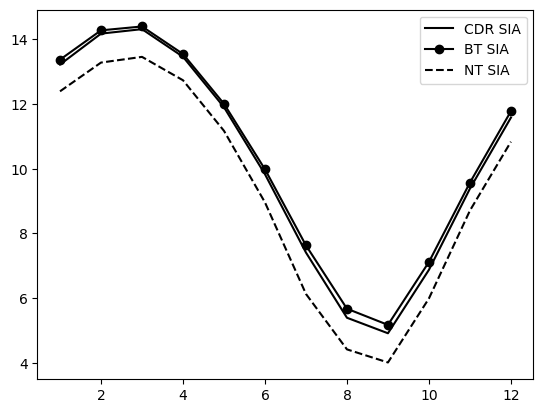

In [37]:
#Find difference between NT and BT in each month of the year for 1995-2014
mon=np.arange(1,13)
plt.plot(mon,SIA_CDR_mclim_1995_2014,label='CDR SIA',color='k');
plt.plot(mon,SIA_BT_mclim_1995_2014,label='BT SIA',color='k',marker='o');
plt.plot(mon,SIA_NT_mclim_1995_2014,label='NT SIA',color='k',linestyle='dashed');
plt.legend()


Average difference between the clim cycle of NT and BT  for 1995-2014 -1.0363995
Sept difference between clim SIA NT and BT -1.1619134


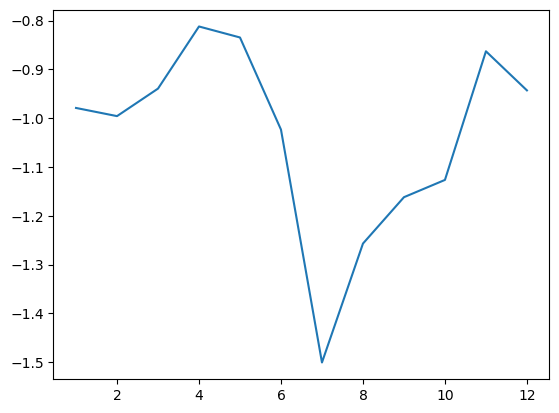

In [38]:
satt_diff=SIA_NT_mclim_1995_2014-SIA_BT_mclim_1995_2014
print('Average difference between the clim cycle of NT and BT  for 1995-2014',np.mean(satt_diff.values))
plt.plot(mon,satt_diff)
print('Sept difference between clim SIA NT and BT',satt_diff.isel(month=8).values) # In Sept

In [39]:
#Make CMIP6 models 1995_2014 means
CMIP6_daily_SIE_SIA_1995_2014_year_mon=to_year_month_day(CMIP6_daily_SIE_SIA_1980_2014).sel(year=slice(1995,2014))

aa=CMIP6_daily_SIE_SIA_1995_2014_year_mon
aa=aa.mean('day').mean('year')

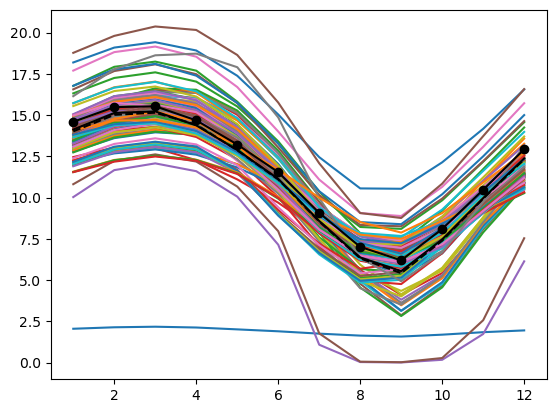

In [40]:
plt.plot(mon,aa['Arctic_SIE'].transpose(),label=aa['GCM'].values);
plt.plot(mon,SIE_CDR_mclim_1995_2014,label='CDR SIE',color='k');
plt.plot(mon,SIE_BT_mclim_1995_2014,label='BT SIA',color='k',marker='o');
plt.plot(mon,SIE_NT_mclim_1995_2014,label='NT SIA',color='k',linestyle='dashed');


In [41]:
#What is the internal variability for the climtological seasonal cycle in CMIP6, 1980-1999? 
# Based on models with =>5 members
MPI_clim=[]
EC_clim=[]
CanESM5_clim=[]
MIROC_clim=[]
ACCESS_clim=[]
CESM2_clim=[]

for GCM_ in np.sort(list(model_and_member.keys())):
    if 'MPI-ESM1-2-LR_' in GCM_:
        temp1=aa['Arctic_SIA'].sel(GCM=GCM_)
        MPI_clim.append(temp1)
    MPI_int_var_clim=np.std(MPI_clim,axis=0)
    if 'CESM2_' in GCM_:
        temp1a=aa['Arctic_SIA'].sel(GCM=GCM_)
        CESM2_clim.append(temp1a)
    CESM2_int_var_clim=np.std(CESM2_clim,axis=0)
    if 'EC-Earth3_' in GCM_:
        temp2=aa['Arctic_SIA'].sel(GCM=GCM_)
        EC_clim.append(temp2)
    EC_int_var_clim=np.std(EC_clim,axis=0)   
    if 'CanESM5_' in GCM_:
        temp3=aa['Arctic_SIA'].sel(GCM=GCM_)
        CanESM5_clim.append(temp3)
    CanESM5_int_var_clim=np.std(CanESM5_clim,axis=0)   
    if 'ACCESS-CM2_' in GCM_:
        temp4=aa['Arctic_SIA'].sel(GCM=GCM_)
        ACCESS_clim.append(temp4)
    ACCESS_int_var_clim=np.std(ACCESS_clim,axis=0)   
    if 'MIROC-ES2L_' in GCM_:
        temp5=aa['Arctic_SIA'].sel(GCM=GCM_)
        MIROC_clim.append(temp5)
    MIROC_int_var_clim=np.std(MIROC_clim,axis=0)   

print('MPI',np.mean(MPI_int_var_clim))
print('EC',np.mean(EC_int_var_clim))
print('CanESM5',np.mean(CanESM5_int_var_clim))
print('MIROC',np.mean(MIROC_int_var_clim))
print('ACCESS',np.mean(ACCESS_int_var_clim))
print('CESM2',np.mean(CESM2_int_var_clim))

Sept_average_int_var=(CanESM5_int_var_clim[8]+MPI_int_var_clim[8]+EC_int_var_clim[8]+MIROC_int_var_clim[8]+ACCESS_int_var_clim[8]+CESM2_int_var_clim[8])/6
print('Sepember Average internal variability 1995-2014',(Sept_average_int_var))

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


MPI 0.15057144436672534
EC 0.982189508599085
CanESM5 0.2959440668874046
MIROC 0.15995540267028815
ACCESS 0.24149121569343304
CESM2 0.1770046811314049
Sepember Average internal variability 1995-2014 0.3828286024429111


In [42]:
#Using +/-0.383, average internal variability in climatological cycle over 1995_2014, for internal variability
# Using SIA_BT for the upper bound, based on plot above, and SIA_NT as lower bound, based on obs plot above
for GCM_ in np.sort(list(model_and_member.keys())):
        if aa['Arctic_SIA'].transpose().sel(GCM=GCM_).isel(month=8)-0.383>SIA_BT_mclim_1995_2014.isel(month=8):
            print(GCM_,'Too high SIA in September in 1995_2014 with',aa['Arctic_SIA'].sel(GCM=GCM_).sel(month=9).values)
            #print(
        if aa['Arctic_SIA'].transpose().sel(GCM=GCM_).isel(month=8)+0.383<SIA_NT_mclim_1995_2014.isel(month=8):
            print(GCM_,'Too low SIA in September in 1995_2014 with',aa['Arctic_SIA'].sel(GCM=GCM_).sel(month=9).values)

AWI-CM-1-1-MR_r1i1p1f1 Too low SIA in September in 1995_2014 with 1.0577705558635788
BCC-CSM2-MR_r1i1p1f1 Too high SIA in September in 1995_2014 with 5.7049296275774655
BCC-ESM1_r1i1p1f1 Too high SIA in September in 1995_2014 with 6.668695782820383
CESM2_r10i1p1f1 Too low SIA in September in 1995_2014 with 2.7826146753629057
CESM2_r1i1p1f1 Too low SIA in September in 1995_2014 with 2.516100008189678
CESM2_r2i1p1f1 Too low SIA in September in 1995_2014 with 1.847089621424675
CESM2_r3i1p1f1 Too low SIA in September in 1995_2014 with 2.4067255666851994
CESM2_r4i1p1f1 Too low SIA in September in 1995_2014 with 2.2779317047198613
CESM2_r5i1p1f1 Too low SIA in September in 1995_2014 with 2.688974532783031
CESM2_r6i1p1f1 Too low SIA in September in 1995_2014 with 2.079725432097911
CESM2_r7i1p1f1 Too low SIA in September in 1995_2014 with 1.9949805468320847
CESM2_r8i1p1f1 Too low SIA in September in 1995_2014 with 2.309111316005389
CESM2_r9i1p1f1 Too low SIA in September in 1995_2014 with 1.85

## Criteria 1 only excludes models where no ensemble member meets the criteria. That means Criteria 1 for 1980-1999 leads to the following models being excluded: NorESM2-MM, NESM3, MPI-ESM1-2-HR, IPSL-CM5A2-INCA, IPSL-CM6A-LR, IPSL-CM6A-LR-INCA, MIROC-ES2H, EC-Earth3-Veg-LR, EC-Earth3-AerChem, GISS-E2-1-G, CMCC-ESM2, CMCC-CM2-SR5, CESM2,  BCC-ESM1, BCC-CSM2-MR, AWI-CM-1-1-MR

## Based on critera 2 we exclude: CMCC-CM2-SR5, EC-Earth3-AerChem, EC-Earth3-CC, EC-Earth3-Veg


In [43]:
selected_model_and_member = {
    'ACCESS-CM2_r1i1p1f1':'ACCESS-CM2_r1i1p1f1',
    'ACCESS-CM2_r2i1p1f1':'ACCESS-CM2_r2i1p1f1',
    'ACCESS-CM2_r3i1p1f1':'ACCESS-CM2_r3i1p1f1',
    'ACCESS-CM2_r4i1p1f1':'ACCESS-CM2_r4i1p1f1',
    'ACCESS-CM2_r5i1p1f1':'ACCESS-CM2_r5i1p1f1',
    'ACCESS-CM2_r6i1p1f1':'ACCESS-CM2_r6i1p1f1',
    'ACCESS-CM2_r7i1p1f1':'ACCESS-CM2_r7i1p1f1',
    'ACCESS-CM2_r8i1p1f1':'ACCESS-CM2_r8i1p1f1',
    'ACCESS-CM2_r9i1p1f1':'ACCESS-CM2_r9i1p1f1',
    'ACCESS-CM2_r10i1p1f1':'ACCESS-CM2_r10i1p1f1',
    'BCC-CSM2-MR_r1i1p1f1':'BCC-CSM2-MR_r1i1p1f1', 
    'CanESM5_r1i1p1f1':'CanESM5_r1i1p1f1',
    'CanESM5_r1i1p2f1':'CanESM5_r1i1p2f1',
    'CanESM5_r2i1p1f1':'CanESM5_r2i1p1f1',
    'CanESM5_r2i1p2f1':'CanESM5_r2i1p2f1',
    'CanESM5_r3i1p1f1':'CanESM5_r3i1p1f1',
    'CanESM5_r3i1p2f1':'CanESM5_r3i1p2f1',
    'CanESM5_r4i1p1f1':'CanESM5_r4i1p1f1',
    'CanESM5_r4i1p2f1':'CanESM5_r4i1p2f1',
    'CanESM5_r5i1p1f1':'CanESM5_r5i1p1f1',
    'CanESM5_r5i1p2f1':'CanESM5_r5i1p2f1',
    'CanESM5_r6i1p1f1':'CanESM5_r6i1p2f1',
    'CanESM5_r6i1p2f1':'CanESM5_r6i1p2f1',
    'CanESM5_r7i1p1f1':'CanESM5_r7i1p1f1',
    'CanESM5_r7i1p2f1':'CanESM5_r7i1p2f1',
    'CanESM5_r8i1p1f1':'CanESM5_r8i1p1f1',
    'CanESM5_r8i1p2f1':'CanESM5_r8i1p2f1',
    'CanESM5_r9i1p1f1':'CanESM5_r9i1p1f1',
    'CanESM5_r9i1p2f1':'CanESM5_r9i1p2f1',
    'CanESM5_r10i1p1f1':'CanESM5_r10i1p1f1',
    'CanESM5_r10i1p2f1':'CanESM5_r10i1p2f1',
    'CNRM-CM6-1-HR_r1i1p1f2':'CNRM-CM6-1-HR_r1i1p1f2', 
    'EC-Earth3_r1i1p1f1':'EC-Earth3_r1i1p1f1',
    'EC-Earth3_r10i1p1f1':'EC-Earth3_r10i1p1f1',
    'EC-Earth3_r12i1p1f1':'EC-Earth3_r12i1p1f1',
    'EC-Earth3_r14i1p1f1':'EC-Earth3_r14i1p1f1',
    'EC-Earth3_r16i1p1f1':'EC-Earth3_r16i1p1f1',
    'IPSL-CM5A2-INCA_r1i1p1f1':'IPSL-CM5A2-INCA_r1i1p1f1',
    'MIROC6_r1i1p1f1':'MIROC6_r1i1p1f1',
    'MIROC6_r2i1p1f1':'MIROC6_r2i1p1f1',
    'MIROC6_r3i1p1f1':'MIROC6_r3i1p1f1',
    'MIROC-ES2L_r10i1p1f2':'MIROC-ES2L_r10i1p1f2',
    'MIROC-ES2L_r1i1p1f2':'MIROC-ES2L_r1i1p1f2',
    'MIROC-ES2L_r2i1p1f2':'MIROC-ES2L_r2i1p1f2', 
    'MIROC-ES2L_r3i1p1f2':'MIROC-ES2L_r3i1p1f2', 
    'MIROC-ES2L_r4i1p1f2':'MIROC-ES2L_r4i1p1f2',
    'MIROC-ES2L_r5i1p1f2':'MIROC-ES2L_r5i1p1f2',
    'MIROC-ES2L_r6i1p1f2':'MIROC-ES2L_r6i1p1f2',
    'MIROC-ES2L_r7i1p1f2':'MIROC-ES2L_r7i1p1f2',
    'MIROC-ES2L_r8i1p1f2':'MIROC-ES2L_r8i1p1f2',
    'MPI-ESM-1-2-HAM_r1i1p1f1':'MPI-ESM-1-2-HAM_r1i1p1f1',
    'MPI-ESM-1-2-HAM_r2i1p1f1':'MPI-ESM-1-2-HAM_r2i1p1f1',
    'MPI-ESM-1-2-HAM_r3i1p1f1':'MPI-ESM-1-2-HAM_r3i1p1f1',
    'MPI-ESM1-2-LR_r1i1p1f1':'MPI-ESM1-2-LR_r1i1p1f1',
    'MPI-ESM1-2-LR_r2i1p1f1':'MPI-ESM1-2-LR_r2i1p1f1',  
    'MPI-ESM1-2-LR_r3i1p1f1':'MPI-ESM1-2-LR_r3i1p1f1',  
    'MPI-ESM1-2-LR_r4i1p1f1':'MPI-ESM1-2-LR_r4i1p1f1',  
    'MPI-ESM1-2-LR_r5i1p1f1':'MPI-ESM1-2-LR_r5i1p1f1',  
    'MPI-ESM1-2-LR_r6i1p1f1':'MPI-ESM1-2-LR_r6i1p1f1',  
    'MPI-ESM1-2-LR_r7i1p1f1':'MPI-ESM1-2-LR_r7i1p1f1',  
    'MPI-ESM1-2-LR_r8i1p1f1':'MPI-ESM1-2-LR_r8i1p1f1',  
    'MPI-ESM1-2-LR_r9i1p1f1':'MPI-ESM1-2-LR_r9i1p1f1',  
    'MPI-ESM1-2-LR_r10i1p1f1':'MPI-ESM1-2-LR_r10i1p1f1',  
    'MPI-ESM1-2-LR_r11i1p1f1':'MPI-ESM1-2-LR_r11i1p1f1',  
    'MPI-ESM1-2-LR_r12i1p1f1':'MPI-ESM1-2-LR_r12i1p1f1',  
    'MPI-ESM1-2-LR_r13i1p1f1':'MPI-ESM1-2-LR_r13i1p1f1',  
    'MPI-ESM1-2-LR_r14i1p1f1':'MPI-ESM1-2-LR_r14i1p1f1',  
    'MPI-ESM1-2-LR_r15i1p1f1':'MPI-ESM1-2-LR_r15i1p1f1',  
    'MPI-ESM1-2-LR_r16i1p1f1':'MPI-ESM1-2-LR_r16i1p1f1',  
    'MPI-ESM1-2-LR_r17i1p1f1':'MPI-ESM1-2-LR_r17i1p1f1',  
    'MPI-ESM1-2-LR_r18i1p1f1':'MPI-ESM1-2-LR_r18i1p1f1',  
    'MPI-ESM1-2-LR_r19i1p1f1':'MPI-ESM1-2-LR_r19i1p1f1',  
    'MPI-ESM1-2-LR_r20i1p1f1':'MPI-ESM1-2-LR_r20i1p1f1',  
    'MPI-ESM1-2-LR_r21i1p1f1':'MPI-ESM1-2-LR_r21i1p1f1',  
    'MPI-ESM1-2-LR_r22i1p1f1':'MPI-ESM1-2-LR_r22i1p1f1',  
    'MPI-ESM1-2-LR_r23i1p1f1':'MPI-ESM1-2-LR_r23i1p1f1',  
    'MPI-ESM1-2-LR_r24i1p1f1':'MPI-ESM1-2-LR_r24i1p1f1',  
    'MPI-ESM1-2-LR_r25i1p1f1':'MPI-ESM1-2-LR_r25i1p1f1',  
    'MPI-ESM1-2-LR_r26i1p1f1':'MPI-ESM1-2-LR_r26i1p1f1',  
    'MPI-ESM1-2-LR_r27i1p1f1':'MPI-ESM1-2-LR_r27i1p1f1',  
    'MPI-ESM1-2-LR_r28i1p1f1':'MPI-ESM1-2-LR_r28i1p1f1',  
    'MPI-ESM1-2-LR_r29i1p1f1':'MPI-ESM1-2-LR_r29i1p1f1',  
    'MPI-ESM1-2-LR_r30i1p1f1':'MPI-ESM1-2-LR_r30i1p1f1',  
    'MPI-ESM1-2-LR_r31i1p1f1':'MPI-ESM1-2-LR_r31i1p1f1',  
    'MPI-ESM1-2-LR_r32i1p1f1':'MPI-ESM1-2-LR_r32i1p1f1',  
    'MPI-ESM1-2-LR_r33i1p1f1':'MPI-ESM1-2-LR_r33i1p1f1',  
    'MPI-ESM1-2-LR_r34i1p1f1':'MPI-ESM1-2-LR_r34i1p1f1',  
    'MPI-ESM1-2-LR_r35i1p1f1':'MPI-ESM1-2-LR_r35i1p1f1',  
    'MPI-ESM1-2-LR_r36i1p1f1':'MPI-ESM1-2-LR_r36i1p1f1',  
    'MPI-ESM1-2-LR_r37i1p1f1':'MPI-ESM1-2-LR_r37i1p1f1',  
    'MPI-ESM1-2-LR_r38i1p1f1':'MPI-ESM1-2-LR_r38i1p1f1',  
    'MPI-ESM1-2-LR_r39i1p1f1':'MPI-ESM1-2-LR_r39i1p1f1',  
    'MPI-ESM1-2-LR_r40i1p1f1':'MPI-ESM1-2-LR_r40i1p1f1',  
    'MPI-ESM1-2-LR_r41i1p1f1':'MPI-ESM1-2-LR_r41i1p1f1',  
    'MPI-ESM1-2-LR_r42i1p1f1':'MPI-ESM1-2-LR_r42i1p1f1',  
    'MPI-ESM1-2-LR_r43i1p1f1':'MPI-ESM1-2-LR_r43i1p1f1',  
    'MPI-ESM1-2-LR_r44i1p1f1':'MPI-ESM1-2-LR_r44i1p1f1',  
    'MPI-ESM1-2-LR_r45i1p1f1':'MPI-ESM1-2-LR_r45i1p1f1',  
    'MPI-ESM1-2-LR_r46i1p1f1':'MPI-ESM1-2-LR_r46i1p1f1',  
    'MPI-ESM1-2-LR_r47i1p1f1':'MPI-ESM1-2-LR_r47i1p1f1',  
    'MPI-ESM1-2-LR_r48i1p1f1':'MPI-ESM1-2-LR_r48i1p1f1',  
    'MPI-ESM1-2-LR_r49i1p1f1':'MPI-ESM1-2-LR_r49i1p1f1',  
    'MPI-ESM1-2-LR_r50i1p1f1':'MPI-ESM1-2-LR_r50i1p1f1',  
    'NorESM2-LM_r1i1p1f1':'NorESM2-LM_r1i1p1f1',
    'NorESM2-LM_r2i1p1f1':'NorESM2-LM_r2i1p1f1',
    'NorESM2-LM_r3i1p1f1':'NorESM2-LM_r3i1p1f1',
}


In [44]:
# Collect just the selected CMIP6 members
file_new=[]
selected_GCM_names = []
       

for GCM_ in np.sort(list(selected_model_and_member.keys())):
    #Save all GCM names in order
    selected_GCM_names.append(GCM_)
    #load the SIE and SIA data file
    file = xr.open_dataset(data_path+'SIA_SIE_hist_{}.nc'.format(GCM_))
    #print(datetime.datetime.now(), GCM_)
    #Check if in million km2 (processed by Alex) or in km2 (processed by Céline) and make all million km2
    if np.max(file['Arctic_SIA']) >100:
        file['Arctic_SIA']=file['Arctic_SIA']/1e12
        file['Arctic_SIE']=file['Arctic_SIE']/1e12
    
    #Remove leap days, if present, so all files have 12775 days for 19800101-20141231
    #print(file.sizes['time'])
    if file.sizes['time'] == 12784 :
        if not type(file) is datetime.date: #If no time dimension, add it
           date = xr.cftime_range(start='1980-01-01', periods=len(file['time']), 
                           freq='D', calendar='standard'
                           )     
           file['time'] = date
           file["time"] = file["time"].astype("datetime64[ns]")

        file=file.convert_calendar('noleap',align_on='date') #remove leap days from obs data 
        #print(file.sizes['time'])
    else:
        #print('Already no leap calendar')
        if not type(file) is datetime.date: #If no time dimension, add it
           date = xr.cftime_range(start='1980-01-01', periods=len(file['time']), 
                           freq='D', calendar='noleap'
                           )     
           file['time'] = date
           file["time"] = file["time"].astype("datetime64[ns]")

    #overwrite time so it's the same in all GCMs to enable averaging by timestep
    dates = xr.cftime_range(start='1980-01-01', periods=len(file['time']), 
                           freq='D', calendar='noleap'
                           )     
    file['time'] = dates

    
    file_new.append(file)
  

In [45]:
Selected_CMIP6_daily_SIE_SIA_1980_2014=xr.concat((file_new), dim='GCM')
Selected_CMIP6_daily_SIE_SIA_1980_2014['GCM'] = selected_GCM_names


In [46]:
#Optional: Save the selected models into combined file. If desired, activiate the lines below
#assign metadata to the NetCDF file
# Selected_CMIP6_daily_SIE_SIA_1980_2014.attrs = {'Description':'Selected Daily CMIP6 Arctic SIE and SIA data in million km2 from the selected GCMs used in Heuze and Jahn (2024), for 1980-01-01 to 2014-12-31 from the historical CMIP6 simulations. Calendar has no leap years.'}

#save to NetCDF file
# Selected_CMIP6_daily_SIE_SIA_1980_2014.to_netcdf('Selected_daily_CMIP6_SIE_SIA_1980_2014.nc')

### 2023 equivalent check in historical data

In [47]:
#Check if any minimum days are below 3.39 (2023 daily minimum) in SIA before end of run

years=np.arange(1980,2015)
for GCM_ in np.sort(list(model_and_member.keys())):
    if SIA_min.sel(GCM=GCM_).sel(year=2014) >= 3.39:
        print('GCM= ',GCM_ )
        print('Is above 2023 values at the daily minimum SIA in 2015, with a SIA of =' , SIA_min.sel(GCM=GCM_).sel(year=2014).values)
    else:
        for y in reversed(range(1980,2015)):
            if SIA_min.sel(GCM=GCM_).sel(year=y) >= 3.39:
                print('GCM= ',GCM_ )
                print('Last year where daily min was above 2023 value, with SIA =' , SIA_min.sel(GCM=GCM_).sel(year=y).values)
                print('In year',y)
                break


GCM=  ACCESS-CM2_r10i1p1f1
Last year where daily min was above 2023 value, with SIA = 3.7599308490753174
In year 2005
GCM=  ACCESS-CM2_r1i1p1f1
Is above 2023 values at the daily minimum SIA in 2015, with a SIA of = 3.738649606704712
GCM=  ACCESS-CM2_r2i1p1f1
Last year where daily min was above 2023 value, with SIA = 3.6980748176574707
In year 2013
GCM=  ACCESS-CM2_r3i1p1f1
Is above 2023 values at the daily minimum SIA in 2015, with a SIA of = 3.755455255508423
GCM=  ACCESS-CM2_r4i1p1f1
Last year where daily min was above 2023 value, with SIA = 3.5237889289855957
In year 2007
GCM=  ACCESS-CM2_r5i1p1f1
Last year where daily min was above 2023 value, with SIA = 4.031338691711426
In year 2013
GCM=  ACCESS-CM2_r6i1p1f1
Last year where daily min was above 2023 value, with SIA = 3.6174325942993164
In year 2008
GCM=  ACCESS-CM2_r7i1p1f1
Last year where daily min was above 2023 value, with SIA = 3.54028582572937
In year 2012
GCM=  ACCESS-CM2_r8i1p1f1
Last year where daily min was above 2023 val